## Imports

In [52]:
import json
import os
import sys

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import PolynomialFeatures

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.initializers import RandomUniform, RandomNormal, HeNormal, GlorotUniform, Constant, Zeros
from keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2


dir_parts = os.getcwd().split(os.path.sep)
root_index = dir_parts.index('ML-B')
root_path = os.path.sep.join(dir_parts[:root_index + 1])
sys.path.append(root_path + '/code/')
from data.data_config import Dataset
from data.data_utils import load_monk, load_cup, store_monk_result, store_cup_result
from hyperparameter_tuning import grid_search, random_search, tuning_search_top_configs
from training.solver import Solver

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Neural Networks
In this notebook we implement and test a custom (feed-forward) Neural Network w.r.t. the tasks at hand, i.e. the three MONK's problem and the CUP dataset. The employed optimizer is Stochastic Gradient Descent (SGD) with mini-batch.

Specifically:
- **get_nn_classifier(...)**: defines the NN classifier for the MONK's problems;
- **get_nn_regressor(...)**: defines the NN regressor for the CUP dataset.

## Settings

In [53]:
MODEL_NAME = 'NN-SGD'
INTERNAL_TEST_SPLIT = 0.1 # internal test split percentage
RANDOM_STATE = 128 # reproducibility
N_SPLITS = 5 # cross-validation
POLY_DEGREE = 3 # polynomial features pre-processing

## Path

In [54]:
# Directories
results_dir = root_path + '/results/' + MODEL_NAME

# Filepaths (MONK)
m1_dev_path, m1_test_path = Dataset.MONK_1.dev_path, Dataset.MONK_1.test_path # MONK 1
m2_dev_path, m2_test_path = Dataset.MONK_2.dev_path, Dataset.MONK_2.test_path # MONK 2
m3_dev_path, m3_test_path = Dataset.MONK_3.dev_path, Dataset.MONK_3.test_path # MONK 3

# Filepaths (CUP)
cup_dev_path, cup_test_path = Dataset.CUP.dev_path, Dataset.CUP.test_path

# MONK-1

In [95]:
# Load MONK-1
x_dev_m1, y_dev_m1, x_test_m1, y_test_m1 = load_monk(m1_dev_path, m1_test_path)

## Model

In [96]:
def get_nn_classifier(hparams):
    initializer = GlorotUniform(seed=RANDOM_STATE) # Glorot (Xavier)
    
    model = Sequential([
        Dense(hparams['h_dim'], activation='tanh', input_shape=(17,), kernel_initializer=initializer),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(hparams['reg']))
    ])
    
    optimizer = SGD(learning_rate=hparams['lr'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    
    model.hparams = hparams
    return model

## Training - Testing

In [ ]:
model_m1 = get_nn_classifier(hparams={'lr': 0.6, 'h_dim': 4, 'reg': 0.0})
solver = Solver(model_m1, x_dev_m1, y_dev_m1, x_test_m1, y_test_m1, target='accuracy')
solver.train(epochs=400, patience=50, batch_size=16)

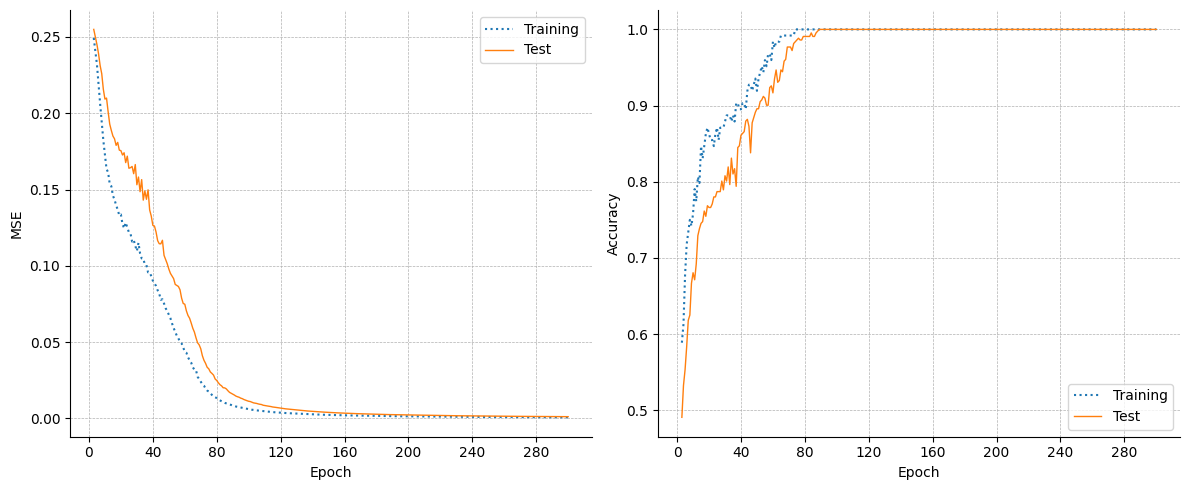

In [64]:
#solver.plot_history(results_dir + '/MONK1/history', 'MSE', 'Accuracy')

In [27]:
print('-- DEVELOPMENT --')
mse_dev_m1, acc_dev_m1 = model_m1.evaluate(x_dev_m1, y_dev_m1)
print(f'Accuracy: {acc_dev_m1:.4f} - MSE: {mse_dev_m1:.4f}')

-- DEVELOPMENT --
4/4 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 1.0000
Accuracy: 1.0000 - MSE: 0.0132


In [28]:
print('-- TEST --')
mse_test_m1, acc_test_m1 = model_m1.evaluate(x_test_m1, y_test_m1)
print(f'Accuracy: {acc_test_m1:.4f} - MSE: {mse_test_m1:.4f}')

-- TEST --
14/14 [==============================] - 0s 1ms/step - loss: 0.0224 - accuracy: 1.0000
Accuracy: 1.0000 - MSE: 0.0224


-- TEST --
14/14 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Accuracy: 1.0000 - MSE: 0.0014


## Store results

In [67]:
report_m1 = {
    'dev': {'accuracy': acc_dev_m1, 'mse': mse_dev_m1},
    'test': {'accuracy': acc_test_m1, 'mse': mse_test_m1}
}

store_monk_result(results_dir + '/MONK1/', model_m1.hparams, report_m1)

# MONK-2

In [29]:
# Load MONK-2
x_dev_m2, y_dev_m2, x_test_m2, y_test_m2 = load_monk(m2_dev_path, m2_test_path)

## Training - Testing

In [ ]:
model_m2 = get_nn_classifier(hparams={'lr': 0.6, 'h_dim': 4, 'reg': 0})
solver = Solver(model_m2, x_dev_m2, y_dev_m2, x_test_m2, y_test_m2, target='accuracy')
solver.train(epochs=400, patience=50, batch_size=64)

In [ ]:
solver.plot_history(results_dir + '/MONK2/history','MSE', 'Accuracy')

In [42]:
print('-- DEVELOPMENT --')
mse_dev_m2, acc_dev_m2 = model_m2.evaluate(x_dev_m2, y_dev_m2)
print(f'Accuracy: {acc_dev_m2:.4f} - MSE: {mse_dev_m2:.4f}')

-- DEVELOPMENT --
6/6 [==============================] - 0s 2ms/step - loss: 0.0162 - accuracy: 1.0000
Accuracy: 1.0000 - MSE: 0.0162


In [43]:
print('-- TEST --')
mse_test_m2, acc_test_m2 = model_m2.evaluate(x_test_m2, y_test_m2)
print(f'Accuracy: {acc_test_m2:.4f} - MSE: {mse_test_m2:.4f}')

-- TEST --
14/14 [==============================] - 0s 0s/step - loss: 0.0230 - accuracy: 1.0000
Accuracy: 1.0000 - MSE: 0.0230


## Store results

In [ ]:
report_m2 = {
    'dev': {'accuracy': acc_dev_m2, 'mse': mse_dev_m2},
    'test': {'accuracy': acc_test_m2, 'mse': mse_test_m2}
}

store_monk_result(results_dir + '/MONK2/', model_m2.hparams, report_m2)

# MONK-3 (no regularization)

In [45]:
# Load MONK-3
x_dev_m3, y_dev_m3, x_test_m3, y_test_m3 = load_monk(m3_dev_path, m3_test_path)

## Training - Testing

In [ ]:
model_m3 = get_nn_classifier(hparams={'lr': 0.6, 'h_dim': 4, 'reg': 0})
solver = Solver(model_m3, x_dev_m3, y_dev_m3, x_test_m3, y_test_m3, target='accuracy')
solver.train(epochs=400, patience=50, batch_size=128)

In [ ]:
solver.plot_history(results_dir + '/MONK3/history','MSE', 'Accuracy')

In [62]:
print('-- DEVELOPMENT --')
mse_dev_m3, acc_dev_m3 = model_m3.evaluate(x_dev_m3, y_dev_m3)
print(f'Accuracy: {acc_dev_m3:.4f} - MSE: {mse_dev_m3:.4f}')

-- DEVELOPMENT --
4/4 [==============================] - 0s 6ms/step - loss: 0.0777 - accuracy: 0.9344
Accuracy: 0.9344 - MSE: 0.0777


In [63]:
print('-- TEST --')
mse_test_m3, acc_test_m3 = model_m3.evaluate(x_test_m3, y_test_m3)
print(f'Accuracy: {acc_test_m3:.4f} - MSE: {mse_test_m3:.4f}')

-- TEST --
14/14 [==============================] - 0s 1000us/step - loss: 0.0699 - accuracy: 0.9722
Accuracy: 0.9722 - MSE: 0.0699


## Store results

In [ ]:
report_m3 = {
    'dev': {'accuracy': acc_dev_m3, 'mse': mse_dev_m3},
    'test': {'accuracy': acc_test_m3, 'mse': mse_test_m3}
}

store_monk_result(results_dir + '/MONK3/', model_m3.hparams, report_m3)

# MONK-3 (with regularization)
MONK3 when setting some regularization value.

## Training - Testing

In [ ]:
model_m3_reg = get_nn_classifier(hparams={'lr': 0.6, 'h_dim': 4, 'reg': 0.001})
solver = Solver(model_m3_reg, x_dev_m3, y_dev_m3,  x_test_m3, y_test_m3, target='accuracy')
solver.train(epochs=400, patience=50, batch_size=128)

In [ ]:
solver.plot_history(results_dir + '/MONK3-reg/history','MSE', 'Accuracy')

In [ ]:
print('-- DEVELOPMENT --')
mse_dev_m3_reg, acc_dev_m3_reg = model_m3_reg.evaluate(x_dev_m3, y_dev_m3)
print(f'Accuracy: {acc_dev_m3_reg:.4f} - MSE: {mse_dev_m3_reg:.4f}')

In [73]:
print('-- TEST --')
mse_test_m3_reg, acc_test_m3_reg = model_m3_reg.evaluate(x_test_m3, y_test_m3)
print(f'Accuracy: {acc_test_m3_reg:.4f} - MSE: {mse_test_m3_reg:.4f}')

-- TEST --
14/14 [==============================] - 0s 923us/step - loss: 0.1061 - accuracy: 0.9722
Accuracy: 0.9722 - MSE: 0.1061


## Store results

In [ ]:
report_m3_reg = {
    'dev': {'accuracy': acc_dev_m3_reg, 'mse': mse_dev_m3_reg},
    'test': {'accuracy': acc_test_m3_reg, 'mse': mse_test_m3_reg}
}

store_monk_result(results_dir + '/MONK3-reg/', model_m3_reg.hparams, report_m3_reg)

# CUP

In [55]:
# Load CUP
x_dev_cup, y_dev_cup, x_test_cup = load_cup(cup_dev_path, cup_test_path)

In [56]:
@keras.utils.register_keras_serializable()
def mean_euclidean_error(y_true: np.ndarray, y_pred: np.ndarray):
    """
    Utility function to compute the Mean Euclidean Error (MEE) between 
    true and predicted values for a tensorflow model. 
    Return the MEE score as a tensor.

    Required arguments:
    - y_true: array containing true values (ground truth).
    - y_pred: array containing predicted values.
    """
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_pred - y_true), axis=-1)))

## Dev - Internal Test Split 
The development dataset is split between training and internal test ($90-10$).

In [57]:
# Split dev data into train - internal test
x_train_cup, x_internal_test_cup, y_train_cup, y_internal_test_cup = train_test_split(
    x_dev_cup, 
    y_dev_cup, 
    test_size=INTERNAL_TEST_SPLIT, 
    random_state=128
)

## Polynomial features pre-processing
We create a version of our dataset to which PolynoMialFeatures pre-processing is applied with a fixed degree.

In [58]:
# --- COMMENT TO USE NON-ENCHANED DATASET --- 
# Polynomial features pre-processing
poly = PolynomialFeatures(degree=POLY_DEGREE)
x_train_cup = poly.fit_transform(x_train_cup)
x_internal_test_cup = poly.transform(x_internal_test_cup)
x_test_cup = poly.transform(x_test_cup)

# NN-SGD (mb)

In [59]:
def get_nn_sgd_regressor(hparams: dict, in_dim: int):
    if hparams['activation'] == 'tanh':
        initializer = GlorotUniform(seed=RANDOM_STATE) # Glorot (Xavier)
        bias_initializer = Zeros()
    elif hparams['activation'] == 'ReLU':
        initializer = HeNormal(seed=RANDOM_STATE) # He (Kaiming)
        bias_initializer = Constant(0.1)
        
    reg = l2(hparams['reg'])
        
    model = Sequential()
    model.add(Dense(
        hparams['h_dim'], 
        activation=hparams['activation'], 
        input_shape=(in_dim,), 
        kernel_regularizer=l2(hparams['reg']),
        kernel_initializer=initializer,
        bias_initializer=bias_initializer))

    h_dim = hparams['h_dim']
    for i in range(hparams['n_layers'] - 1):
        model.add(
            Dense(
                h_dim, 
                activation=hparams['activation'],
                kernel_regularizer=l2(hparams['reg']),
                kernel_initializer=initializer,
                bias_initializer=bias_initializer))
        h_dim //= 2
        
    model.add(Dense(
        3, 
        activation='linear', 
        kernel_regularizer=l2(hparams['reg']), 
        kernel_initializer=initializer,
        bias_initializer=bias_initializer))

    optimizer = SGD(learning_rate=hparams['lr'], momentum=hparams['momentum'])
    model.compile(optimizer=optimizer, loss='mse', metrics=[mean_euclidean_error])
    return model

## Hyper-parameters Tuning
A common approach is to start with a coarse search across a wide range of values to find promising sub-ranges of our parameter space. Then, you would zoom into these ranges and perform another search to fine-tune the configurations.

Here, we proceed as follows:
1. (coarse) Grid-search across a wide range of hyper-paramaters and values;
2. (fine-tune) Random-search into zoomed intervals w.r.t. best configuration found by grid-search.

Then, we perform a single run of grid-search and random-search with the respectively best configurations while taking into account a PolynomialFeatures pre-processing with fixed degree. The best configurations that will be used for final re-training and evaluation on internal test is the one with the best mean MEE on the validation cross-validation.

Note that, tuning of the polynomial degree wasn't performed because it would be very expensive. Thus, we simply decided to use a fixed degree value.

### Grid Search

In [ ]:
grid_search_spaces_cup = {
    'lr': [0.01, 0.001, 0.0001],
    'n_layers': [2, 3],
    'h_dim': [32, 64, 128],
    'activation': ['tanh'],
    'reg': [0.01, 0.001],
    'momentum': [0.9],
    'batch_size': [32, 64, 128],
}

In [ ]:
# Grid search (coarse)
best_model_coarse, best_config_coarse, results_coarse = grid_search(
    get_nn_sgd_regressor, 
    x_train_cup,
    y_train_cup,
    grid_search_spaces_cup, 
    target='mean_euclidean_error', 
    N_SPLITS=N_SPLITS,
    EPOCHS=800, 
    PATIENCE=50
)

### Random Search

In [ ]:
# set new intervals for fine-tune random search
lr = best_config_coarse['lr']
n_layers = best_config_coarse['n_layers']
h_dim = best_config_coarse['h_dim']
activation = best_config_coarse['activation']
reg = best_config_coarse['reg']
momentum = best_config_coarse['momentum']
batch_size = best_config_coarse['batch_size']

In [ ]:
random_search_spaces_cup = {
    'lr': ([0.01, 0.004], 'float'),
    'n_layers': ([2, 3], 'item'),
    'h_dim': ([64, 80, 100], 'item'),
    'activation': (['tanh'], 'item'),
    'reg': ([0.001], 'item'),
    'momentum': ([0.93, 0.98], 'float'),
    'batch_size': ([32], 'item'),
}

In [ ]:
# Random search (fine-tune)
best_model_finetune, best_config_finetune, results_finetune = random_search(
    get_nn_sgd_regressor, 
    x_train_cup,
    y_train_cup,
    random_search_spaces_cup, 
    target='mean_euclidean_error', 
    N_SPLITS=N_SPLITS,
    NUM_SEARCH=20,
    EPOCHS=800, 
    PATIENCE=50
)

### Save tuning results

In [ ]:
mee_coarse = best_config_coarse['mean_euclidean_error']
mee_finetune = best_config_finetune['mean_euclidean_error']

best_config_cup = best_config_finetune if mee_finetune < mee_coarse else best_config_coarse

In [ ]:
# Store grid-search
best_config_coarse['n_layers'] = int(best_config_coarse['n_layers'])
best_config_coarse['h_dim'] = int(best_config_coarse['h_dim'])
best_config_coarse['batch_size'] = int(best_config_coarse['batch_size'])
with open(results_dir + '/CUP/grid_search.json', 'w') as outf:
    json.dump(best_config_coarse, outf, indent=4)
    
# Store random-search
best_config_finetune['n_layers'] = int(best_config_finetune['n_layers'])
best_config_finetune['h_dim'] = int(best_config_finetune['h_dim'])
best_config_finetune['batch_size'] = int(best_config_finetune['batch_size'])
with open(results_dir + '/CUP/random_search.json', 'w') as outf:
    json.dump(best_config_finetune, outf, indent=4)

## Training

In [60]:
best_config_cup = {
    'lr': 0.00035,
    'h_dim': 100,
    'n_layers': 3,
    'activation': 'tanh',
    'reg': 0.001,
    'momentum': 0.95, 
    'batch_size': 32,
}

In [ ]:
# Final re-training on entire training set (EarlyStopping on train MEE)
model_nn_cup = get_nn_sgd_regressor(best_config_cup, x_train_cup.shape[1])
solver = Solver(model_nn_cup, x_train_cup, y_train_cup, x_internal_test_cup, y_internal_test_cup, target='mean_euclidean_error')
solver.train(epochs=800, patience=50)

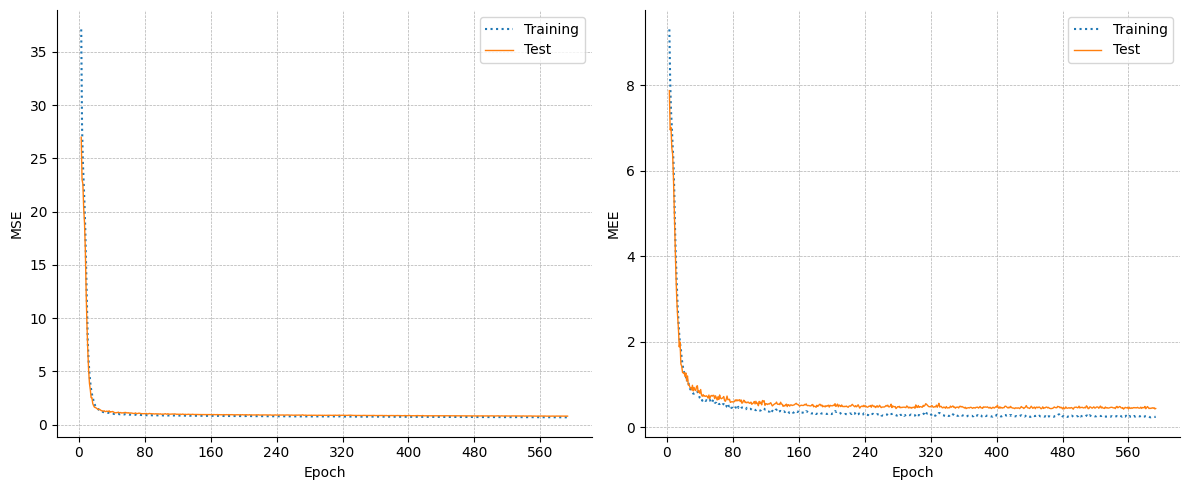

In [42]:
solver.plot_history(results_dir + '/CUP/history_poly', loss='MSE', metric='MEE')

In [63]:
print('-- TRAINING --')
loss_train_cup, mee_train_cup = model_nn_cup.evaluate(x_train_cup, y_train_cup)
print(f'Loss (MSE): {loss_train_cup:.4f} -  MEE: {mee_train_cup:.4f}')

-- TRAINING --
29/29 [==============================] - 0s 1ms/step - loss: 0.7300 - mean_euclidean_error: 0.2371
Loss (MSE): 0.7300 -  MEE: 0.2371


In [64]:
print('-- INTERNAL TEST --')
loss_internal_test_cup, mee_internal_test_cup = model_nn_cup.evaluate(x_internal_test_cup, y_internal_test_cup)
print(f'Loss (MSE): {loss_internal_test_cup:.4f} -  MEE: {mee_internal_test_cup:.4f}')

-- INTERNAL TEST --
4/4 [==============================] - 0s 2ms/step - loss: 0.8095 - mean_euclidean_error: 0.4411
Loss (MSE): 0.8095 -  MEE: 0.4411


## Blind Test Predictions

In [65]:
# Blind test set predictions
nn_preds_cup = model_nn_cup.predict(x_test_cup)

29/29 [==============================] - 0s 1ms/step


## Store Result

In [66]:
# Store model
model_nn_cup.save(results_dir + '/CUP/model_sgd_poly.keras')

In [67]:
# Store report
report_nn = {
    'train': {'mse': loss_train_cup, 'mee': mee_train_cup},
    'internal_test': {'mse': loss_internal_test_cup, 'mee': mee_internal_test_cup}
}

store_cup_result(results_dir + '/CUP/', best_config_cup, report_nn, nn_preds_cup, is_poly=True)